# TP 1: LDA/QDA y optimización matemática de modelos

# Librerias

In [6]:
import numpy as np
import numpy.linalg as LA

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from base.qda import QDA, TensorizedQDA
from base.cholesky import QDA_Chol1, QDA_Chol2, QDA_Chol3
from utils.bench import Benchmark
from utils.datasets import (get_iris_dataset, get_letters_dataset, 
                            get_penguins_dataset, get_wine_dataset,
                            label_encode)

# Intro teórica

## Distribución Normal Multivariada

### Definición

Es una generalización de la distribución normal unidimensional a dimensiones superiores.

$X \in \mathbb{R}^p$ tiene distribución normal multivariada representada por $X \sim \mathcal{N}_p(\mu, \Sigma)$ con media $\mu$ y covarianza $\Sigma$ si su función de densidad es:

$$
f_X(x) = \frac{1}{(2 \pi)^{\frac{p}{2}} \cdot |\Sigma|^{\frac{1}{2}}}
\, e^{- \frac{1}{2}(x-\mu)^\top \Sigma^{-1} (x- \mu)}
$$

donde:
- $\mu \in \mathbb{R}^p$ es el vector de medias.
- $\Sigma \in \mathbb{R}^{p \times p}$ es la matriz de covarianza, simétrica y definida positiva (invertible).

### Interpretación Normal Bivariada

Con $p = 2$, se tiene:

$$(X, Y)^\top \sim \mathcal{N}_2(\mu, \Sigma)$$

donde:

$$
\mu =
\begin{bmatrix}
\mu_x \\
\mu_y
\end{bmatrix},
\quad
\Sigma =
\begin{bmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y & \sigma_y^2
\end{bmatrix},
\quad
\rho = \frac{\text{Cov}(X,Y)}{\sigma_x \, \sigma_y}.
$$

Las curvas de nivel de la densidad $f(x,y)$ son elipses centradas en $\mu$. La orientación y forma de estas elipses dependen de la matriz de covarianza $\Sigma$.

#### Casos bivariados según varianzas y correlación

1) **$\sigma_x^2 = \sigma_y^2 = \sigma^2$, $\rho = 0$**  
$$
\Sigma =
\begin{bmatrix}
\sigma^2 & 0 \\
0 & \sigma^2
\end{bmatrix}
= \sigma^2 I
$$
- Curvas de nivel: círculos.  
- $X$ e $Y$ independientes.

2) **$\sigma_x^2 \neq \sigma_y^2$, $\rho = 0$**  
$$
\Sigma =
\begin{bmatrix}
\sigma_x^2 & 0 \\
0 & \sigma_y^2
\end{bmatrix}
$$
- Curvas de nivel: elipses alineadas a los ejes.  
- $X$ e $Y$ independientes con distinta dispersión por eje.

3) **$\sigma_x^2 \neq \sigma_y^2$, $\rho \neq 0$**  
$$
\Sigma =
\begin{bmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y & \sigma_y^2
\end{bmatrix}, \quad \rho \in (-1,1)
$$
- Curvas de nivel: elipses inclinadas rotadas respecto a los ejes.  
- $X$ e $Y$ dependientes .

#### Gráficas

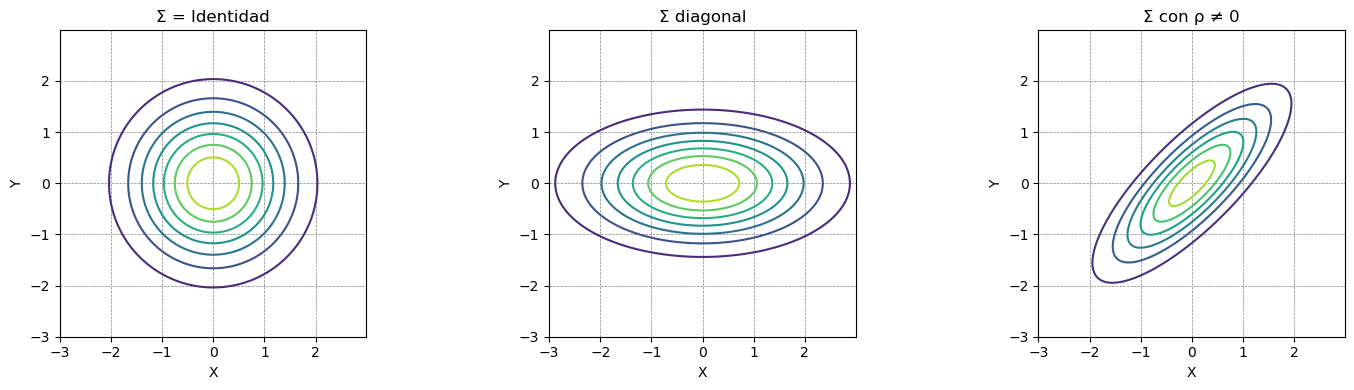

In [9]:
# Media en el origen

mu = np.array([0, 0])
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# Tres matrices de covarianza

covs = [
    np.array([[1, 0], [0, 1]]),      # Identidad
    np.array([[2, 0], [0, 0.5]]),    # Diagonal
    np.array([[1, 0.8], [0.8, 1]])   # Correlación positiva (ρ=0.8)
]

titles = [
    "Σ = Identidad",
    "Σ diagonal",
    "Σ con ρ ≠ 0"
]

# Crear subplots en una fila

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, cov, title in zip(axes, covs, titles):
    rv = multivariate_normal(mean=mu, cov=cov)
    ax.contour(x, y, rv.pdf(pos))
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

## Clasificadores de discriminante cuadrático y lineal (QDA/LDA)

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

### QDA

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Algoritmo QDA

### 1) Entrenamiento (estimación por máxima verosimilitud)

Para cada clase $j$ se debe estimar:

1) Probabilidad a priori:
$$
\hat{\pi}_j = \frac{n_j}{n}, \qquad n_j=\#\{i:\, y_i=j\}, \qquad n=\sum_{j=1}^J n_j
$$
2) Vecto de medias:
$$
\hat{\mu}_j=\frac{1}{n_j}\sum_{i:\,y_i=j} x_i = \bar{x}_j
$$
3) Matriz de covarianza:
$$
\hat{\Sigma}_j=\frac{1}{n_j}\sum_{i:\,y_i=j}(x_i-\hat{\mu}_j)(x_i-\hat{\mu}_j)^\top=s^2_j
$$


### 2) Predicción (clasificación)

1) Función discriminante por clase:
$$
\delta_j(x)=
-\tfrac12\log|\hat{\Sigma}_j|
-\tfrac12(x-\hat{\mu}_j)^\top \hat{\Sigma}_j^{-1}(x-\hat{\mu}_j)
+\log \hat{\pi}_j
$$

2) Regla de decisión:
$$
\hat{y}(x)=\arg\max_{j}\,\delta_j(x)
$$

3) Probabilidad posterior de cada clase (no requerido para clasificar)
$$
P(y=j\mid x)=
\frac{\exp\{\delta_j(x)\}}
{\sum_{j} \exp\{\delta_j(x)\}}
$$

4) Estabilización numérica para evitar desbordamientos:
$$
Sea \; m=\max_{k}\delta_k(x),\quad
P(y=j\mid x)=\frac{\exp\{\delta_j(x)-m\}}{\sum_{k=1}^{J}\exp\{\delta_k(x)-m\}}
$$

## Algoritmo LDA

### 1) Entrenamiento (estimación por máxima verosimilitud)

Para cada clase $j$ se debe estimar:

1) Probabilidad a priori:
$$
\hat{\pi}_j = \frac{n_j}{n}, \qquad n_j=\#\{i:\, y_i=j\}, \qquad n=\sum_{j=1}^J n_j
$$
2) Vecto de medias:
$$
\hat{\mu}_j = \frac{1}{n_j}\sum_{i:\,y_i=j} x_i = \bar{x}_j
$$
3) Matriz de covarianza: en LDA todas las clases comparten la misma matriz de covarianza:
$$
\hat{\Sigma} \;=\; \frac{1}{n}\,\sum_{j=1}^{J}\;\sum_{i:\,y_i=j}
\bigl(x_i-\hat{\mu}_j\bigr)\bigl(x_i-\hat{\mu}_j\bigr)^\top = \hat{\Sigma} \;=\; \frac{1}{n}\,\sum_{j=1}^{J} n_{j}\, s_{j}^{2}
$$

### 2) Predicción (clasificación)

1) Función discriminante por clase:
$$
\delta_j(x)=
\mu_j^\top \Sigma^{-1}\!\left(x - \tfrac{1}{2}\mu_j\right)
+\log \hat{\pi}_j
$$

2) Regla de decisión:
$$
\hat{y}(x)=\arg\max_{j}\,\delta_j(x)
$$

3) Probabilidad posterior de cada clase (no requerido para clasificar)
$$
P(y=j\mid x)=
\frac{\exp\{\delta_j(x)\}}
{\sum_{j} \exp\{\delta_j(x)\}}
$$

4) Estabilización numérica para evitar desbordamientos:
$$
Sea \; m=\max_{k}\delta_k(x),\quad
P(y=j\mid x)=\frac{\exp\{\delta_j(x)-m\}}{\sum_{k=1}^{J}\exp\{\delta_k(x)-m\}}
$$

# Consigna QDA

**Notación**: en general notamos

* $k$ la cantidad de clases
* $n$ la cantidad de observaciones
* $p$ la cantidad de features/variables/predictores

**Sugerencia:** combinaciones adecuadas de `transpose`, `stack`, `reshape` y, ocasionalmente, `flatten` y `diagonal` suele ser más que suficiente. Se recomienda *fuertemente* explorar la dimensionalidad de cada elemento antes de implementar las clases.

## Tensorización

En esta sección nos vamos a ocupar de hacer que el modelo sea más rápido para generar predicciones, observando que incurre en un doble `for` dado que predice en forma individual un escalar para cada observación, para cada clase. Paralelizar ambos vía tensorización suena como una gran vía de mejora de tiempos.

### 1) Diferencias entre `QDA`y `TensorizedQDA`

1. ¿Sobre qué paraleliza `TensorizedQDA`? ¿Sobre las $k$ clases, las $n$ observaciones a predecir, o ambas?
2. Analizar los shapes de `tensor_inv_covs` y `tensor_means` y explicar paso a paso cómo es que `TensorizedQDA` llega a predecir lo mismo que `QDA`.

### 2) Optimización

Debido a la forma cuadrática de QDA, no se puede predecir para $n$ observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de $n \times n$ en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

3. Implementar el modelo `FasterQDA` (se recomienda heredarlo de `TensorizedQDA`) de manera de eliminar el ciclo for en el método predict.
4. Mostrar dónde aparece la mencionada matriz de $n \times n$, donde $n$ es la cantidad de observaciones a predecir.
5. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de $n \times n$ usando matrices de $n \times p$. También se puede usar, de forma equivalente,
$$
np.sum(A^T \odot B, axis=0).T
$$
queda a preferencia del alumno cuál usar.
6. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente en un nuevo modelo `EfficientQDA`.
7. Comparar la performance de las 4 variantes de QDA implementadas hasta ahora (no Cholesky) ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Cholesky

Hasta ahora todos los esfuerzos fueron enfocados en realizar una predicción más rápida. Los tiempos de entrenamiento (teóricos al menos) siguen siendo los mismos o hasta (minúsculamente) peores, dado que todas las mejoras siguen llamando al método `_fit_params` original de `QDA`.

La descomposición/factorización de [Cholesky](https://en.wikipedia.org/wiki/Cholesky_decomposition#Statement) permite factorizar una matriz definida positiva $A = LL^T$ donde $L$ es una matriz triangular inferior. En particular, si bien se asume que $p \ll n$, invertir la matriz de covarianzas $\Sigma$ para cada clase impone un cuello de botella que podría alivianarse. Teniendo en cuenta que las matrices de covarianza son simétricas y salvo degeneración, definidas positivas, Cholesky como mínimo debería permitir invertir la matriz más rápido.

*Nota: observar que calcular* $A^{-1}b$ *equivale a resolver el sistema* $Ax=b$.

### 3) Diferencias entre implementaciones de `QDA_Chol`

8. Si una matriz $A$ tiene fact. de Cholesky $A=LL^T$, expresar $A^{-1}$ en términos de $L$. ¿Cómo podría esto ser útil en la forma cuadrática de QDA?
7. Explicar las diferencias entre `QDA_Chol1`y `QDA` y cómo `QDA_Chol1` llega, paso a paso, hasta las predicciones.
8. ¿Cuáles son las diferencias entre `QDA_Chol1`, `QDA_Chol2` y `QDA_Chol3`?
9. Comparar la performance de las 7 variantes de QDA implementadas hasta ahora ¿Qué se observa?¿Hay alguna de las implementaciones de `QDA_Chol` que sea claramente mejor que las demás?¿Alguna que sea peor?

### 4) Optimización

12. Implementar el modelo `TensorizedChol` paralelizando sobre clases/observaciones según corresponda. Se recomienda heredarlo de alguna de las implementaciones de `QDA_Chol`, aunque la elección de cuál de ellas queda a cargo del alumno según lo observado en los benchmarks de puntos anteriores.
13. Implementar el modelo `EfficientChol` combinando los insights de `EfficientQDA` y `TensorizedChol`. Si se desea, se puede implementar `FasterChol` como ayuda, pero no se contempla para el punto.
13. Comparar la performance de las 9 variantes de QDA implementadas ¿Qué se observa? A modo de opinión ¿Se condice con lo esperado?

## Importante:

Las métricas que se observan al realizar benchmarking son muy dependientes del código que se ejecuta, y por tanto de las versiones de las librerías utilizadas. Una forma de unificar esto es utilizando un gestor de versiones y paquetes como _uv_ o _Poetry_, otra es simplemente usando una misma VM como la que provee Colab.

**Cada equipo debe informar las versiones de Python, NumPy y SciPy con que fueron obtenidos los resultados. En caso de que sean múltiples, agregar todos los casos**. La siguiente celda provee una ayuda para hacerlo desde un notebook, aunque como es una secuencia de comandos también sirve para consola.

In [12]:
# Version que deberia funcionar en todos los entornos

import sys
print("Python:", sys.version)

# importlib.metadata es estándar desde Python 3.8; en Colab también está.
try:
    from importlib.metadata import version, PackageNotFoundError
except Exception:
    from importlib_metadata import version, PackageNotFoundError  # backport, por si acaso

for pkg in ["numpy", "scipy"]:
    try:
        print(f"{pkg}:", version(pkg))
    except PackageNotFoundError:
        print(f"{pkg}: NO INSTALADO")

Python: 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 15:47:54) [MSC v.1941 64 bit (AMD64)]
numpy: 1.26.4
scipy: 1.15.2
